### Defining Functions:

In [1]:
import numpy as np
from scipy.special import factorial as f

Z = 2
e = (1.602e-19 * np.sqrt(1/(4*np.pi*8.854e-12))) # J
e_sq_raw = e**2
e_sq = (e**2 / 1.6e-19) * 1e10 #14.4 # eV A
hbar_raw = (6.63e-34 / (2*np.pi))
hbar = hbar_raw * 1e10 # A
pi = np.pi
m_e_raw = 9.11e-31 # kg 
m_e = m_e_raw * 1e10 # kg A
r0 = (hbar_raw**2 / (e_sq_raw*m_e_raw)) * 1e10 # 0.5297 # A, hbar**2/m_e*e**2

def expectation_C(vals1,vals2,chi,Z=Z,r0=r0,e=e,return_for_JKM=False): # checked
    j,k,m = vals1
    j2,k2,m2 = vals2
    J,K,M = j+j2,k+k2,m+m2
    lmbd = ((chi*r0)/Z)**(-1)

    if K % 2 == 0 and M != -2:
        C = 8*pi**2 * f(J+K+M+4) * (1/(2*lmbd)**(J+K+M+5)) * (1/(M+2)) * (1/(K+1) - 1/(K+M+3))
    else:
        C = 0
    if return_for_JKM:
        return C
    else:
        return -Z*e_sq*C

def expectation_N(vals1,vals2,chi,Z=Z,r0=r0): # checked
    j,k,m = vals1
    j2,k2,m2 = vals2
    J,K,M = j+j2,k+k2,m+m2
    lmbd = ((chi*r0)/Z)**(-1)
    if K % 2 == 0 and M != -2:
        N = 2*pi**2 * f(J+K+M+5) * 1/(2*lmbd)**(J+K+M+6) * (1/(M+2)) * (1/(K+1) - 1/(K+M+3)- 1/(K+3) + 1/(K+M+5))
    else:
        N = 0
    return N

def expectation_W(vals1,vals2,chi,r0=r0,Z=Z,e=e,show=False): # checked
    temp_vals1 = vals1.copy()
    temp_vals1[-1] -= 1
    return e_sq*expectation_N(temp_vals1,vals2,chi,r0=r0,Z=Z)
    
def expectation_T(vals1,vals2,chi,Z=Z,r0=r0,show=False): # checked
    j,k,m = vals1
    j2,k2,m2 = vals2
    J,K,M = j+j2,k+k2,m+m2
    lmbd = Z/(chi*r0)
    
    N1 = expectation_N([j,k,m],[j2,k2,m2],chi,Z=Z,r0=r0)
    N2 = expectation_N([j-1,k,m],[j2,k2,m2],chi,Z=Z)
    N3 = expectation_N([j-2,k,m],[j2,k2,m2],chi,Z=Z)
    N4 = expectation_N([j,k-2,m],[j2,k2,m2],chi,Z=Z)
    N5 = expectation_N([j,k,m-2],[j2,k2,m2],chi,Z=Z)
    C1 = expectation_C([j,k,m],[j2,k2,m2],chi,Z=Z,r0=r0,return_for_JKM=True)
    C2 = expectation_C([j,k+2,m-2],[j2,k2,m2],chi,Z=Z,r0=r0,return_for_JKM=True)
    C3 = expectation_C([j-1,k,m],[j2,k2,m2],chi,Z=Z,r0=r0,return_for_JKM=True)
    C4 = expectation_C([j-1,k+2,m-2],[j2,k2,m2],chi,Z=Z,r0=r0,return_for_JKM=True)
    C5 = expectation_C([j+1,k,m-2],[j2,k2,m2],chi,Z=Z,r0=r0,return_for_JKM=True)
    C6 = expectation_C([j-1,k,m],[j2,k2,m2],chi,Z=Z,r0=r0,return_for_JKM=True)

    T = (r0*e_sq/2) * ( 2*(lmbd**2*N1 - J*lmbd*N2 + j*j2*N3 + k*k2*N4 + m*m2*N5) + 0.5*(-M*lmbd*(C1-C2)+(m*j2+j*m2)*(C3-C4)+(m*k2+m2*k)*(C5-C6)) )
    return T

def findEigen(matrix): # checked
    eigenvals,eigenvects = np.linalg.eig(matrix)
    presort = zip(eigenvals,eigenvects.T)
    postsort = sorted(presort,key=lambda pair: pair[0],reverse=False)
    eigenvals,eigenvects = zip(*postsort)
    return list(eigenvals),list(eigenvects)

def buildDiagonal(diagElements): # checked
    R = len(diagElements)
    diag = np.zeros((R,R),dtype=np.single)
    for i,val in enumerate(diagElements):
        diag[i][i] = val 
    return diag

def buildEigenVectorMatrix(eigenvectorArray): # checked
    EigenVecMatrix = np.array(eigenvectorArray).T
    return EigenVecMatrix

def invRootDiagonal(diagonalMatrix): # checked
    inverse_root_matrix = np.zeros((len(diagonalMatrix),len(diagonalMatrix)),dtype=np.single)
    for i in range(len(diagonalMatrix)):
        if diagonalMatrix[i][i] != 0:
            inverse_root_matrix[i][i] = 1 / np.sqrt(diagonalMatrix[i][i])
        else:
            inverse_root_matrix[i][i] = 0
    return inverse_root_matrix

def rootDiagonal(diagonalMatrix): # checked
    root_matrix = np.zeros((len(diagonalMatrix),len(diagonalMatrix)),dtype=np.single)
    for i in range(len(diagonalMatrix)):
        root_matrix[i][i] = np.sqrt(diagonalMatrix[i][i])
    return root_matrix

def expectation_H(vals1,vals2,chi,r0=r0,Z=Z,e=e): # checked
    return expectation_T(vals1,vals2,chi,r0=r0,Z=Z,show=True) + expectation_W(vals1,vals2,chi,r0=r0,Z=Z,e=e,show=False) + expectation_C(vals1,vals2,chi,r0=r0,Z=Z,return_for_JKM=False)

### Helium atom simulation:

In [2]:
states = [[0,3,0],[0,0,1],[0,2,0]]
chis = np.arange(0.5,5,0.1)

def find_energy_eigenvalues(states,chi):
    H = np.zeros((len(states),len(states)),dtype=np.single)
    N = np.zeros((len(states),len(states)),dtype=np.single)
    
    for row,(j,k,m) in enumerate(states):
        for col,(j2,k2,m2) in enumerate(states):
            H[row][col] = expectation_H([j,k,m],[j2,k2,m2],chi=chi)
            N[row][col] = expectation_N([j,k,m],[j2,k2,m2],chi=chi)
            
    N_eigenvals,N_eigenvects = findEigen(N)

    beta = buildDiagonal(N_eigenvals)
    Y = buildEigenVectorMatrix(N_eigenvects)
    beta_minus_half = invRootDiagonal(beta)
    
    P = beta_minus_half @ Y.T @ H @ Y @ beta_minus_half

    approx_Es,z = findEigen(P)
    # 'z' represents the eigernvectors of P, ie. z.
    E_approx = sorted(approx_Es)[0]
    
    def returnAs(beta,Y,E,z=z):
        beta_minus_half = invRootDiagonal(beta)
        Y_T_inv = np.linalg.inv(Y.T)
        A = [Y_T_inv @ beta_minus_half @ z[i] for i in range(len(z))] # return the vector A for the best energy approximation
        return A
    
    return E_approx,approx_Es,returnAs(beta,Y,E_approx,z)

Es = [find_energy_eigenvalues(states,chi)[0] for chi in chis]
bestApprox = min(Es)
print('Approximate energy level: {:.2f} eV'.format(bestApprox))

Approximate energy level: -71.22 eV


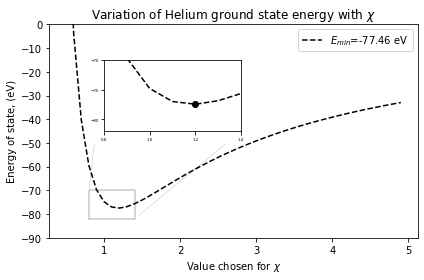

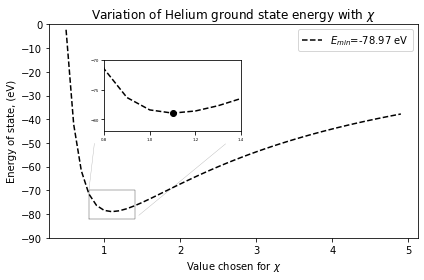

[-77.46469, -78.966705]


In [3]:
import matplotlib.pyplot as plt
import os
import plottools
import random

file_dir = os.path.abspath('')

states_array = [[[0,0,0]],[[0,0,0],[0,0,1],[0,2,0]]]

'''numbers = [5,7,10,15,20]

for i in range(len(numbers)):
    cache = []
    for k in range(numbers[i]):
        cache.append([random.randint(1,len(numbers)),2*random.randint(1,len(numbers)),0])#random.randint(1,len(numbers))])
    states_array.append(cache)
    print(states_array[-1])'''

minimum = []

for num in range(len(states_array)):

    Es = [find_energy_eigenvalues(states_array[num],chi)[0] for chi in chis]
    bestApprox = min(Es)
    minimum.append(bestApprox)

    E2 = [find_energy_eigenvalues(states,chi)[1][-2] for chi in chis]
    E3 = [find_energy_eigenvalues(states,chi)[1][-1] for chi in chis]

    fig,ax = plt.subplots()
    ax.plot(chis,Es,'k--',label=r'$E_{{min}}$={0:.2f} eV'.format(bestApprox))
    #ax.plot(chis,E2,'r--',label=r'$E_{{001}}$={0:.2f} eV'.format(min(E2)))
    #ax.plot(chis,E3,'b--',label=r'$E_{{020}}$={0:.2f} eV'.format(min(E3)))
    ax.set_title(r'Variation of Helium ground state energy with $\chi$')
    ax.set_xlabel(r'Value chosen for $\chi$')
    ax.set_ylabel(r'Energy of state, (eV)')
    ax.legend(loc='upper right')
    ax.set_ylim(-90,0)

    zoomed_ax = plottools.zoom_axes(fig,ax,zoom_x=[0.8,1.4],zoom_y=[-82,-70],axes_x=[1,2.8],axes_y=[-45,-15],box=True)
    zoomed_ax.plot(chis,Es,'k--')
    zoomed_ax.plot(chis[Es.index(min(Es))],min(Es),'ko')

    fig.savefig('ground state plot '+str(len(states_array[num]))+'.png')
    plt.show()
    
print(minimum)

#print('Approximate E2 energy level: {:.2f} eV'.format(min(E2)))
#print('Approximate E3 energy level: {:.2f} eV'.format(min(E3)))